# 3. 카메라 스티커 앱


박창근님 깃허브 참고

https://github.com/LilPark/AIFFEL_project/blob/main/Exploration_03/%5BE-03%5DCameraSticker.ipynb



In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib

- dlib: 얼굴의 랜드마크를 분리하기 위해서 사용

## 1. Image preparation

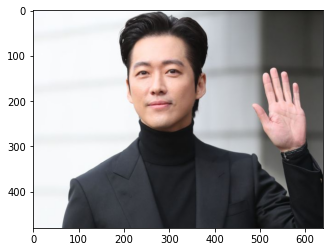

In [3]:
my_image_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)  #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 480))  # 640x360의 크기로 Resize
img_show = img_bgr.copy() #- 출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

- OpenCV를 이용하여 이미지를 읽어온 후, 출력
- resize와 cvtColor을 이용하여 이미지의 사이즈와 색 처리
- cvtColor를 사용하는 이유: OpenCV는 BGR 포멧을 사용하기 때문에, RGB 포멧으로 변환해야함

## 2. Face detection

rectangles[[(201, 98) (356, 253)]]


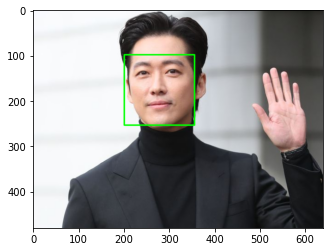

In [4]:
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)

print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

- dlib을 이용하여, 이미지 내 얼굴 영역의 좌표를 출력하고, box 처리
- detector_hog: 이미지 피라미드에서 얼굴을 다시 검출하면, 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능 (두 번째 파라미터 = 이미지 피라미드의 수)
- dlib detector는 dlib.rectangles 타입의 객체를 반환
- dlib.rectangle 객체는 left(), top(), right(), bottom(), height(), width() 등의 함수를 포함

## 3. Face landmark

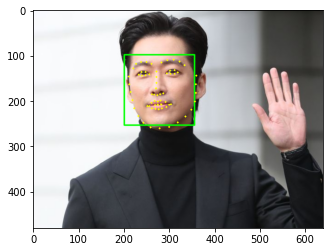

In [5]:
model_path = os.getenv("HOME") + '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

- top-down 방식과 이미지 내 box를 이용하여 landmark를 출력
- list_landmarks 변수는 68개의 tuple (x, y)로 이루어져 있는 리스트
- 특정 landmark 포인트를 이용하여 스티커를 부착

## 4. Apply sticker

In [6]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[33])
    x = landmark[33][0]
    y = landmark[33][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print('(x, y): (%d, %d)'%(x, y))
    print('(w, h): (%d, %d)'%(w, h))

(274, 187)
(x, y): (274, 187)
(w, h): (156, 156)


- 고양이 수염 스티커를 붙이기 위해서, 코의 중심 좌표를 이용(landmark[33])
- 스티커의 위치(x, y)와 크기(w, h)를 출력

(156, 156, 3)


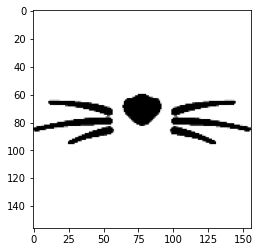

In [8]:
sticker_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))
print(img_sticker.shape)

plt.imshow(img_sticker)
plt.show()

- 스티커의 이미지를 읽어온 후, 위에서 계산한 크기(w, h)를 이용하여 스티커를 resize

In [9]:
refined_x = x - w // 2
refined_y = y - w // 2
print('(x, y): (%d, %d)'%(refined_x, refined_y))

(x, y): (196, 109)


- 위에서 계산한 위치(x, y)를 이미지의 시작점에 맞게 재설정

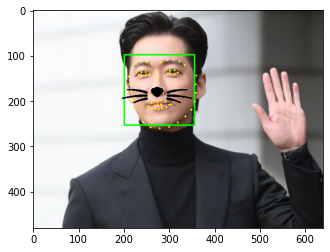

In [10]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)
#     np.where(img_sticker==0, img_sticker, sticker_area).astype(np.uint8)


plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- 원본 이미지에 스티커 적용 후 결과 출력
- 이미지에 스티커를 적용할 시, 스티커의 흰색 배경이 함께 나타나는 현상이 발생(마지막 회고 부분에 기술)

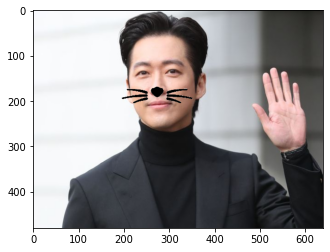

In [11]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

- box와 landmark를 제거한 후, 최종 결과 출력

# 회고

- 안경을 쓰고 있는 이미지나, 스티커의 회전 방법에 대해서는 새싹러들의 여러 의견이 분분했으나,
배웠던 내용으로는 하기 힘들었다.
- 누군가는 새로운 라이브러리를 가져와서 적용하니까 회전이 되었다고 하는것 보니
해당되는 라이브러리를 잘 알고있다면 적용이 쉬울것 같다.
- 처음 배울때는 헷깔렸던 내용이 많은 노드를 읽어보면서 좀 이해가 되기 시작하는것 같다.